In [1]:
from glob import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import re
import nltk
from collections import defaultdict
from scipy import spatial

# Dataset Prep

In [2]:
df = pd.read_excel("InputTestSet-Reviews48_Ann.xlsx")

In [3]:
df.head()

,UID,PID,Dec,Sent,MComp,Cat,SubCat
0,0,2019_SJf_XhCqKm,Reject,The authors propose to use k-DPP to select a s...,0,NaN,NaN
1,1,2019_SJf_XhCqKm,Reject,"This paper covers the related work nicely, wit...",0,NaN,NaN
2,2,2019_SJf_XhCqKm,Reject,The rest of the paper are also clearly written.,0,NaN,NaN
3,3,2019_SJf_XhCqKm,Reject,"However, I have some concerns about the propos...",0,NaN,NaN
4,4,2019_SJf_XhCqKm,Reject,"- It is not clear how to define the kernel, th...",0,NaN,NaN


In [4]:
df.shape

(1505, 7)

In [5]:
gt_dict = {}

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    if not pid in gt_dict:
        gt_dict[pid] = {"dec": df.loc[i]["Dec"], "mcomp": set(), "not_mcomp": set()}
    if df.loc[i]["MComp"] == 1:
        gt_dict[pid]["mcomp"].add(df.loc[i]["UID"])
    else:
        gt_dict[pid]["not_mcomp"].add(df.loc[i]["UID"])

In [6]:
stats_dict = {"Accept": [0, 0], "Reject": [0, 0]}

for k, v in gt_dict.items():
    #print(len(v["mcomp"]), len(v["not_mcomp"]), v["dec"])
    stats_dict[v["dec"]][0] += len(v["mcomp"])
    stats_dict[v["dec"]][1] += len(v["not_mcomp"])
    
print(stats_dict)

{'Accept': [48, 644], 'Reject': [69, 744]}


In [7]:
test_set = list(gt_dict.keys())
print("TestSet length: %d\n"%len(test_set), test_set)

TestSet length: 32
 ['2019_SJf_XhCqKm', '2017_Bk0MRI5lg', '2020_SyevYxHtDB', '2018_rJBiunlAW', '2020_rkltE0VKwH', '2018_Hki-ZlbA-', '2019_BJx0sjC5FX', '2020_r1e_FpNFDr', '2020_B1lsXREYvr', '2018_SkZxCk-0Z', '2019_rJzoujRct7', '2018_HkfXMz-Ab', '2017_BJ9fZNqle', '2019_SyxZJn05YX', '2017_B1ckMDqlg', '2017_HJ0NvFzxl', '2017_S1_pAu9xl', '2018_SyYYPdg0-', '2017_BJAA4wKxg', '2019_HyVxPsC9tm', '2019_HylTBhA5tQ', '2019_B1l08oAct7', '2018_H135uzZ0-', '2017_H1oyRlYgg', '2017_r1y1aawlg', '2020_r1eX1yrKwB', '2020_Byg79h4tvB', '2019_H1lFZnR5YX', '2020_BkeWw6VFwr', '2018_HyHmGyZCZ', '2018_HyUNwulC-', '2020_HkgsPhNYPS']


In [8]:
for k in test_set:
    print('{:20}{}'.format(k, gt_dict[k]["mcomp"]))

2019_SJf_XhCqKm     {39, 17, 20, 27, 28, 30}
2017_Bk0MRI5lg      {48, 57}
2020_SyevYxHtDB     {76, 87}
2018_rJBiunlAW      {108, 110, 112, 113, 124, 126}
2020_rkltE0VKwH     {160, 155, 184, 159}
2018_Hki-ZlbA-      {267, 235, 236, 271}
2019_BJx0sjC5FX     {292, 287}
2020_r1e_FpNFDr     {312, 322, 315, 308}
2020_B1lsXREYvr     {376, 401}
2018_SkZxCk-0Z      {449, 443, 445, 486}
2019_rJzoujRct7     {518, 519}
2018_HkfXMz-Ab      {573, 566}
2017_BJ9fZNqle      {627, 623, 615}
2019_SyxZJn05YX     {672, 673, 657, 669, 671}
2017_B1ckMDqlg      {714, 707}
2017_HJ0NvFzxl      {739}
2017_S1_pAu9xl      {792, 809, 810, 806}
2018_SyYYPdg0-      {834, 867, 868, 869, 870, 872, 873, 844, 830}
2017_BJAA4wKxg      {884}
2019_HyVxPsC9tm     {931, 933, 905, 909, 912, 913, 919, 926}
2019_HylTBhA5tQ     {972, 950}
2019_B1l08oAct7     {994, 996, 1064, 1004, 1007, 1044, 1047, 1048, 1055}
2018_H135uzZ0-      {1072, 1079}
2017_H1oyRlYgg      set()
2017_r1y1aawlg      {1125, 1162, 1100, 1102, 1168}
2020_r1eX1y

In [9]:
sents_for_test = defaultdict(list)

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    sents_for_test[pid].append((df.loc[i]["UID"], df.loc[i]["Sent"]))

# A. SciBERT

In [9]:
import spacy
import torch

In [10]:
from transformers import AutoTokenizer, AutoModel

In [11]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

model = AutoModel.from_pretrained("allenai/scibert_scivocab_cased")

In [12]:
def embed_text_using_scibert(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
    return last_hidden_states

In [34]:
scibert_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    scibert_vectors[pid] = {}
#     scibert_vectors[pid]["not_mcomp"] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            vec = embed_text_using_scibert(df.loc[mcs]["Sent"]).mean(1).detach().numpy()
            scibert_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            vec = embed_text_using_scibert(df.loc[mcs]["Sent"]).mean(1).detach().numpy()
            scibert_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
        

2019_HyVxPsC9tm 938 2
2019_HyVxPsC9tm 940 3
2018_HyHmGyZCZ 1425 2


In [35]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1385


In [67]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)
sim_with_mcomp_paper_sents = defaultdict(dict)

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(scibert_vectors[mcomp_sentences[osid]][osid], scibert_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_mcomp[sid]["min"] = min(temp_list)
    sim_with_mcomp[sid]["max"] = max(temp_list)
    sim_with_mcomp[sid]["mean"] = np.mean(temp_list)
    
    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(scibert_vectors[not_mcomp_sentences[osid]][osid], scibert_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_not_mcomp[sid]["min"] = min(temp_list)
    sim_with_not_mcomp[sid]["max"] = max(temp_list)
    sim_with_not_mcomp[sid]["mean"] = np.mean(temp_list)
    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(scibert_vectors[not_mcomp_sentences[osid]][osid], scibert_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_notmcomp_paper_sents[sid]["min"] = min(temp_list)
    sim_with_notmcomp_paper_sents[sid]["max"] = max(temp_list)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(temp_list)
    
    # 4. With mcomp_sentences of the same paper
    temp_list = []    
    for osid in mcomp_sentences:
        if mcomp_sentences[osid] == mcomp_sentences[sid] and osid!=sid:
            temp_list.append(np.inner(scibert_vectors[mcomp_sentences[osid]][osid], scibert_vectors[mcomp_sentences[sid]][sid])[0][0])
    if len(temp_list) > 0:
        sim_with_mcomp_paper_sents[sid]["min"] = min(temp_list)
        sim_with_mcomp_paper_sents[sid]["max"] = max(temp_list)
        sim_with_mcomp_paper_sents[sid]["mean"] = np.mean(temp_list)

### Plot

In [121]:
# max_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["max"] - sim_with_not_mcomp[sid]["max"])
    diff13.append(sim_with_mcomp[sid]["max"] - sim_with_notmcomp_paper_sents[sid]["max"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

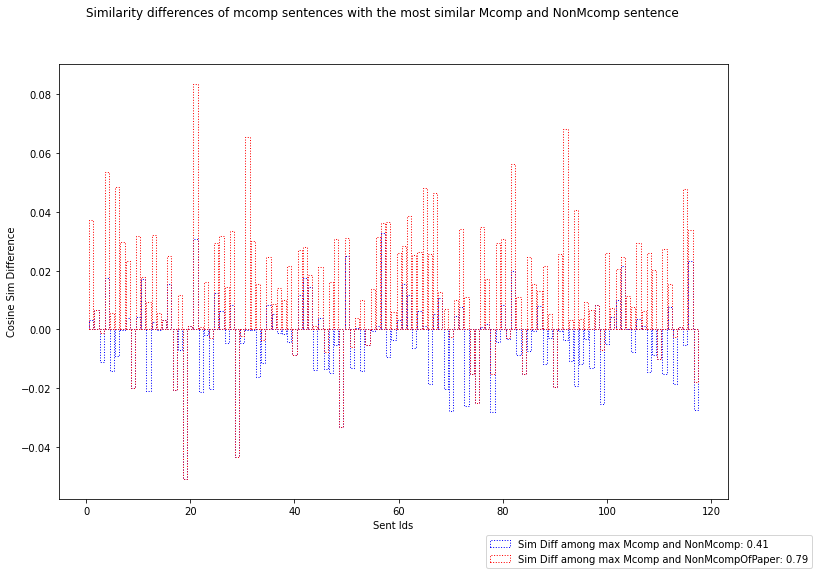

In [122]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among max Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among max Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("Similarity differences of mcomp sentences with the most similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/max_diff_sb.png', dpi=300)

In [123]:
# min_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["min"] - sim_with_not_mcomp[sid]["min"])
    diff13.append(sim_with_mcomp[sid]["min"] - sim_with_notmcomp_paper_sents[sid]["min"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

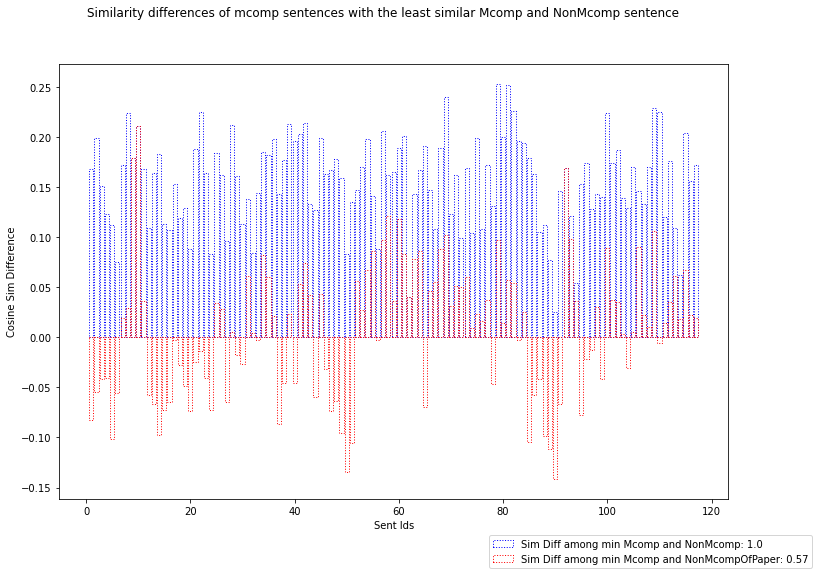

In [124]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among min Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among min Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("Similarity differences of mcomp sentences with the least similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')


plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/min_diff_sb.png', dpi=300)

In [125]:
# mean_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13.append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

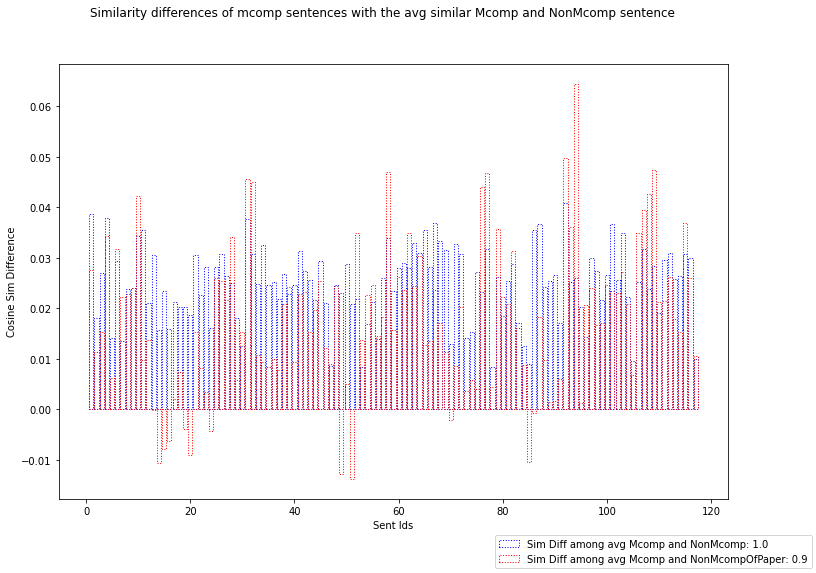

In [126]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among avg Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among avg Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/mean_diff_sb.png', dpi=300)

# B. USE

In [10]:
import tensorflow as tf
import tensorflow_hub as hub

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [11]:
embed_text_using_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [15]:
use_vectors = defaultdict(dict)
skip_uids = [938, 940, 1425]

for pid in gt_dict:
    use_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            vec = embed_text_using_use([df.loc[mcs]["Sent"]])
            use_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in [938, 940, 1425]:
            try:
                vec = embed_text_using_use([df.loc[mcs]["Sent"]])
                use_vectors[pid][mcs] = vec / norm(vec)
            except Exception as ex:
                print(pid, mcs, df.loc[mcs]["Sent"])
                skip_uids.append(mcs)
        

In [16]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1385


In [17]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)
sim_with_mcomp_paper_sents = defaultdict(dict)

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(use_vectors[mcomp_sentences[osid]][osid], use_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_mcomp[sid]["min"] = min(temp_list)
    sim_with_mcomp[sid]["max"] = max(temp_list)
    sim_with_mcomp[sid]["mean"] = np.mean(temp_list)
    
    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(use_vectors[not_mcomp_sentences[osid]][osid], use_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_not_mcomp[sid]["min"] = min(temp_list)
    sim_with_not_mcomp[sid]["max"] = max(temp_list)
    sim_with_not_mcomp[sid]["mean"] = np.mean(temp_list)
    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(use_vectors[not_mcomp_sentences[osid]][osid], use_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sim_with_notmcomp_paper_sents[sid]["min"] = min(temp_list)
    sim_with_notmcomp_paper_sents[sid]["max"] = max(temp_list)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(temp_list)
    
    # 4. With mcomp_sentences of the same paper
    temp_list = []    
    for osid in mcomp_sentences:
        if mcomp_sentences[osid] == mcomp_sentences[sid] and osid!=sid:
            temp_list.append(np.inner(use_vectors[mcomp_sentences[osid]][osid], use_vectors[mcomp_sentences[sid]][sid])[0][0])
    if len(temp_list) > 0:
        sim_with_mcomp_paper_sents[sid]["min"] = min(temp_list)
        sim_with_mcomp_paper_sents[sid]["max"] = max(temp_list)
        sim_with_mcomp_paper_sents[sid]["mean"] = np.mean(temp_list)

### Plot

In [31]:
# max_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["max"] - sim_with_not_mcomp[sid]["max"])
    diff13.append(sim_with_mcomp[sid]["max"] - sim_with_notmcomp_paper_sents[sid]["max"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

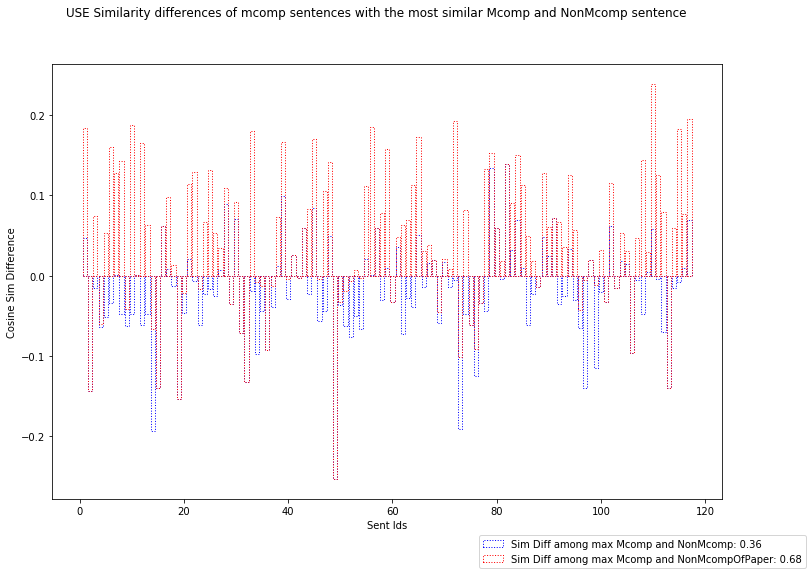

In [32]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among max Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among max Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("USE Similarity differences of mcomp sentences with the most similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/max_diff_USE.png', dpi=300)

In [33]:
# min_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["min"] - sim_with_not_mcomp[sid]["min"])
    diff13.append(sim_with_mcomp[sid]["min"] - sim_with_notmcomp_paper_sents[sid]["min"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

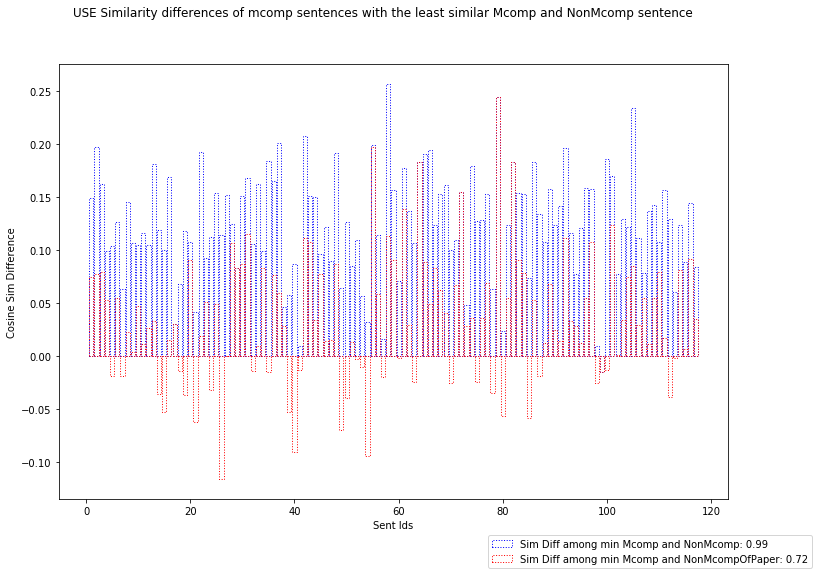

In [34]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among min Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among min Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("USE Similarity differences of mcomp sentences with the least similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')


plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/min_diff_USE.png', dpi=300)

In [35]:
# mean_sim_plot
diff12 = []
diff13 = []

for sid in sim_with_mcomp:
    diff12.append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13.append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])

v1 = round(sum(i > 0 for i in diff12)/len(diff12), 2)
v2 = round(sum(i > 0 for i in diff13)/len(diff13), 2)

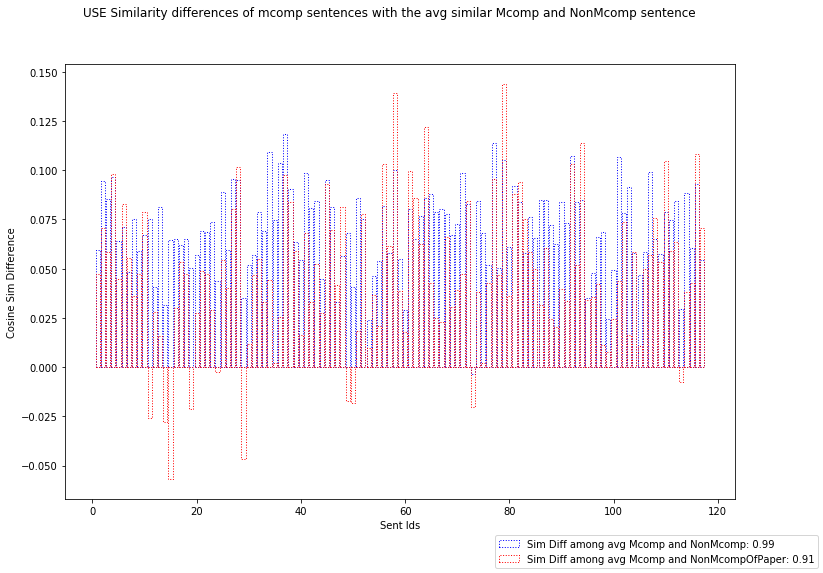

In [36]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12,8))

rects1 = axs.bar(list(range(1,len(diff12)+1)), diff12, fill=False, edgecolor='blue', linestyle='dotted', label="Sim Diff among avg Mcomp and NonMcomp: {}".format(v1))
rects2 = axs.bar(list(range(1,len(diff13)+1)), diff13, fill=False, edgecolor='red', linestyle='dotted', label="Sim Diff among avg Mcomp and NonMcompOfPaper: {}".format(v2))

fig.suptitle("USE Similarity differences of mcomp sentences with the avg similar Mcomp and NonMcomp sentence")

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.setp(axs, xlabel="Sent Ids", ylabel="Cosine Sim Difference")

plt.savefig('plots/mean_diff_USE.png', dpi=300)